In [1]:
import sys
sys.path.append('/Users/kiralyb/Documents/GitHub/CogModelingRNNsTutorial/')

#@title Imports + defaults settings.
#%load_ext autoreload
#%autoreload 2

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import warnings
import importlib


warnings.filterwarnings("ignore")

try:
    from google.colab import files
    _ON_COLAB = True
except:
    _ON_COLAB = False

from CogModelingRNNsTutorial import bandits
from CogModelingRNNsTutorial import disrnn
from CogModelingRNNsTutorial import hybrnn
from CogModelingRNNsTutorial import plotting
from CogModelingRNNsTutorial import rat_data
from CogModelingRNNsTutorial import rnn_utils

from scipy.io import loadmat

In [2]:
#@title Set up environment
import random  # Import the random module

n_actions = 2
trialnum = 300 #@param {type:"integer"}
#environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies) #, predif_sequence = [2,1,0,1,0,0,0,1,1])
environment_vol = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=[30,60,90], reward_probs=[0.9,0.9,0.9]) # 30 trials of volatility and 60 trials of extremity
# Generate a random sequence of 0s and 1s
# Generate a balanced random sequence of 0s and 1s
half_trials = (trialnum // 60) + 1
predif_sequence = [0] * half_trials + [1] * half_trials
random.shuffle(predif_sequence)
environment_ext = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=[60, 60],reward_probs=[0.66, 0.9],predif_sequence=predif_sequence) # 30 trials of volatility and 60 trials of extremity

environment_fast = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=[30,30], reward_probs=[0.9]) # 30 trials of volatility and 60 trials of extremity
environment_slow = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=[90,90], reward_probs=[0.9]) # 30 trials of volatility and 60 trials of extremity

environment_pred = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=[60,60], reward_probs=[0.9]) # 30 trials of volatility and 60 trials of extremity
environment_unpred = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=[60,60], reward_probs=[0.66]) # 30 trials of volatility and 60 trials of extremity

environment_full = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=[30,60,90], reward_probs=[0.66,0.9]) 

import numpy as np
import random
import matplotlib.pyplot as plt

# Define the parameter space
alpha_range = np.arange(0, 1.1, 0.1)  # Alpha values from 0 to 1 with 0.1 steps
beta_range = np.arange(0, 6.5, 0.5)   # Beta values from 0 to 5 with 0.1 steps

# Initialize a matrix to store collected rewards
reward_matrix = np.zeros((len(alpha_range), len(beta_range), 7)) 

# Loop through the parameter space
for i, alpha in enumerate(alpha_range):
    for j, beta in enumerate(beta_range):
        # Define the RL parameters for the agent
        #@title Agent behavior: **One session**

        rewards_vol_list = []
        rewards_ext_list = []
        rewards_slow_list = []
        rewards_fast_list = []
        rewards_pred_list = []
        rewards_unpred_list = []
        rewards_full_list = []
        # Run the experiment for each environment
        
        for _ in range(100):  # Train 10 times
            agent = bandits.AgentQ(alpha=alpha, beta=beta, perseveration_bias=2)  
            experiment_vol = bandits.run_flip_experiment(agent=agent,
                   environment=environment_vol,
                   n_trials=trialnum)
            experiment_ext = bandits.run_flip_experiment(agent=agent,
                   environment=environment_ext,
                   n_trials=trialnum)          
            experiment_slow = bandits.run_flip_experiment(agent=agent,
                   environment=environment_slow,
                   n_trials=trialnum)
            experiment_fast = bandits.run_flip_experiment(agent=agent,
                   environment=environment_fast,
                   n_trials=trialnum)            
            experiment_pred = bandits.run_flip_experiment(agent=agent,
                   environment=environment_unpred,
                   n_trials=trialnum)
            experiment_unpred = bandits.run_flip_experiment(agent=agent,
                   environment=environment_pred,
                   n_trials=trialnum)
            experiment_full = bandits.run_flip_experiment(agent=agent,
                   environment=environment_full,
                   n_trials=trialnum)
            


            # Collect the average rewards
            rewards_vol_list.append(sum(experiment_vol.rewards) /len(experiment_ext.rewards)) 
            rewards_ext_list.append(sum(experiment_ext.rewards)/len(experiment_ext.rewards))
            rewards_slow_list.append(sum(experiment_slow.rewards)/len(experiment_slow.rewards))
            rewards_fast_list.append(sum(experiment_fast.rewards)/len(experiment_fast.rewards))
            rewards_unpred_list.append(sum(experiment_pred.rewards)/len(experiment_pred.rewards))
            rewards_pred_list.append(sum(experiment_unpred.rewards)/len(experiment_unpred.rewards))
            rewards_full_list.append(sum(experiment_full.rewards)/len(experiment_full.rewards))

        # Store the average rewards in the reward matrix
        reward_matrix[i, j, 0] = np.mean(rewards_vol_list)  # Store the reward in the matrix
        reward_matrix[i, j, 1] = np.mean(rewards_ext_list)
        reward_matrix[i, j, 2] = np.mean(rewards_slow_list)
        reward_matrix[i, j, 3] = np.mean(rewards_fast_list) 
        reward_matrix[i, j, 4] = np.mean(rewards_pred_list)
        reward_matrix[i, j, 5] = np.mean(rewards_unpred_list)
        reward_matrix[i, j, 6] = np.mean(rewards_full_list)



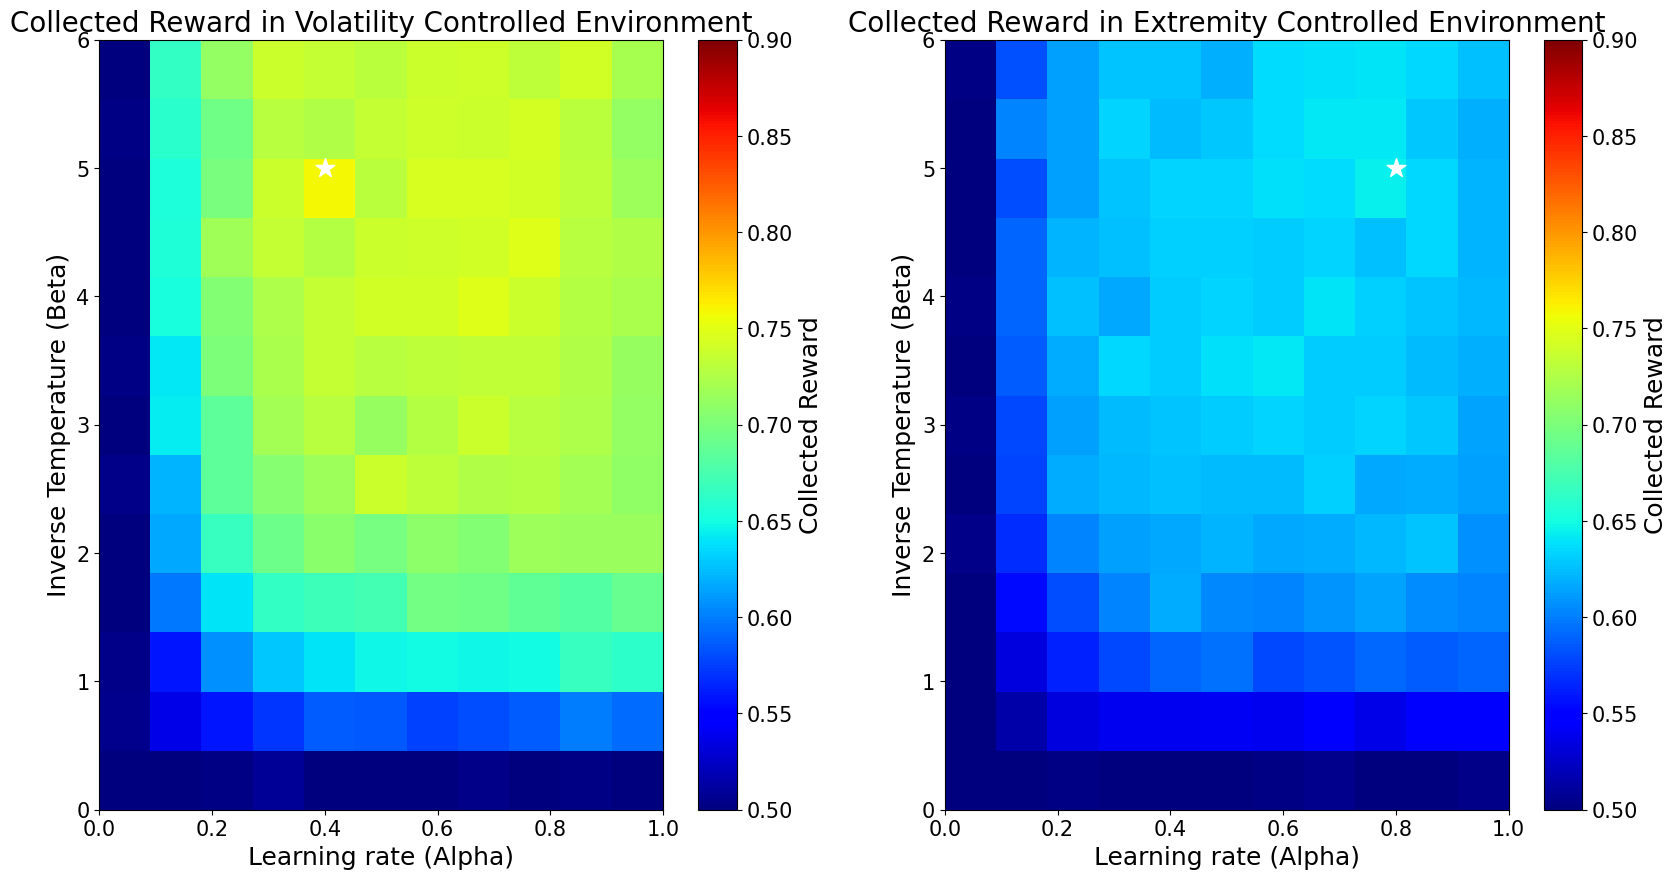

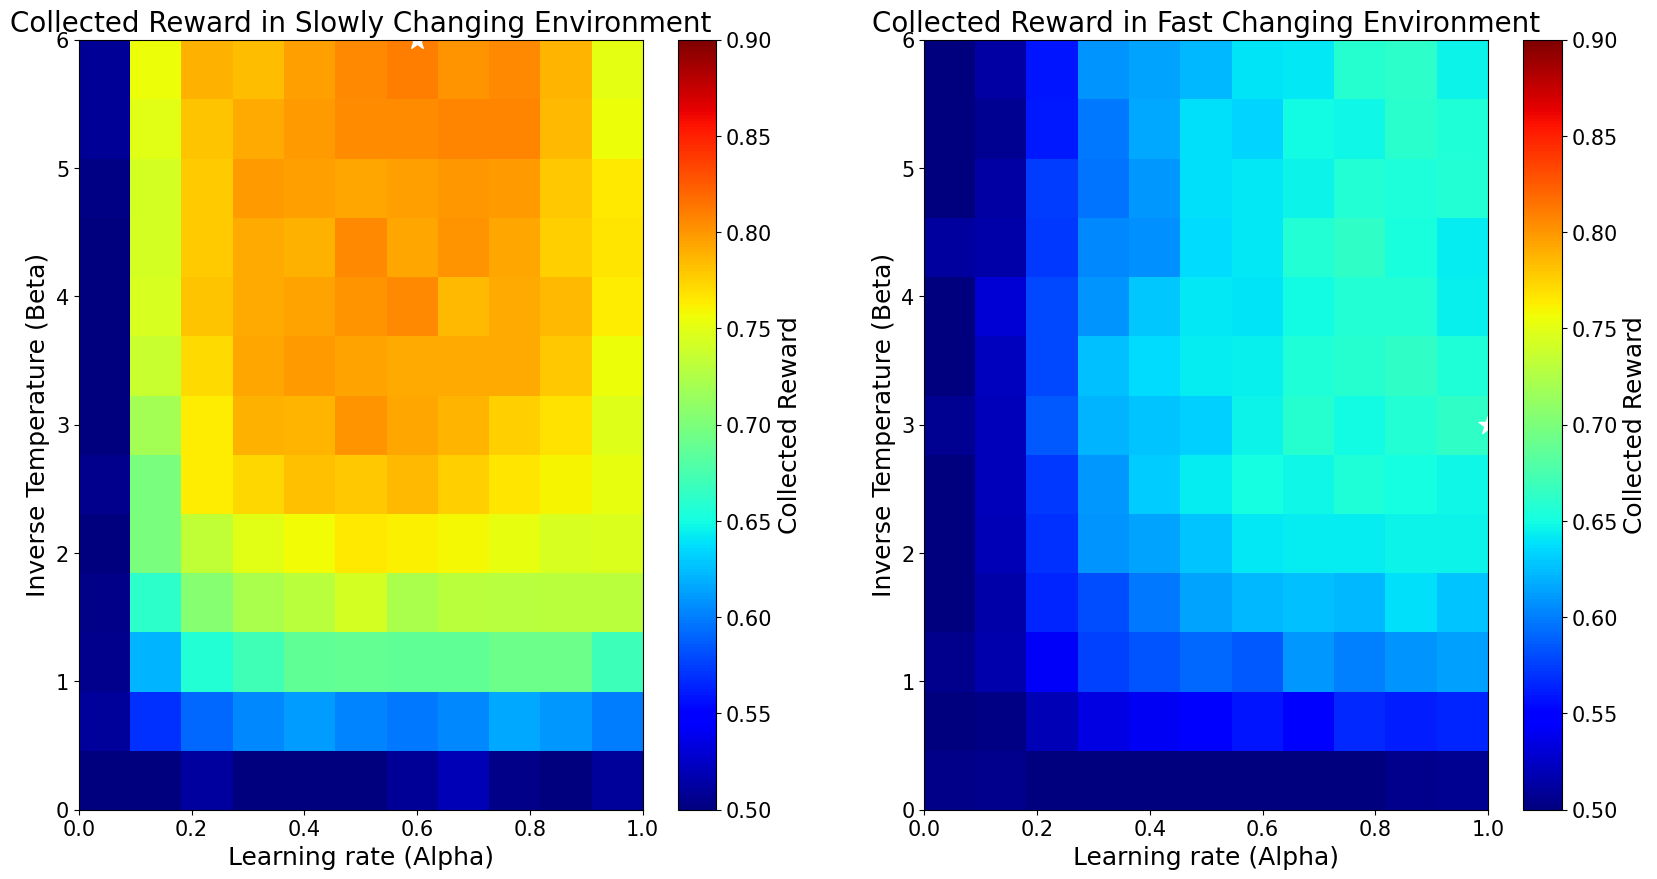

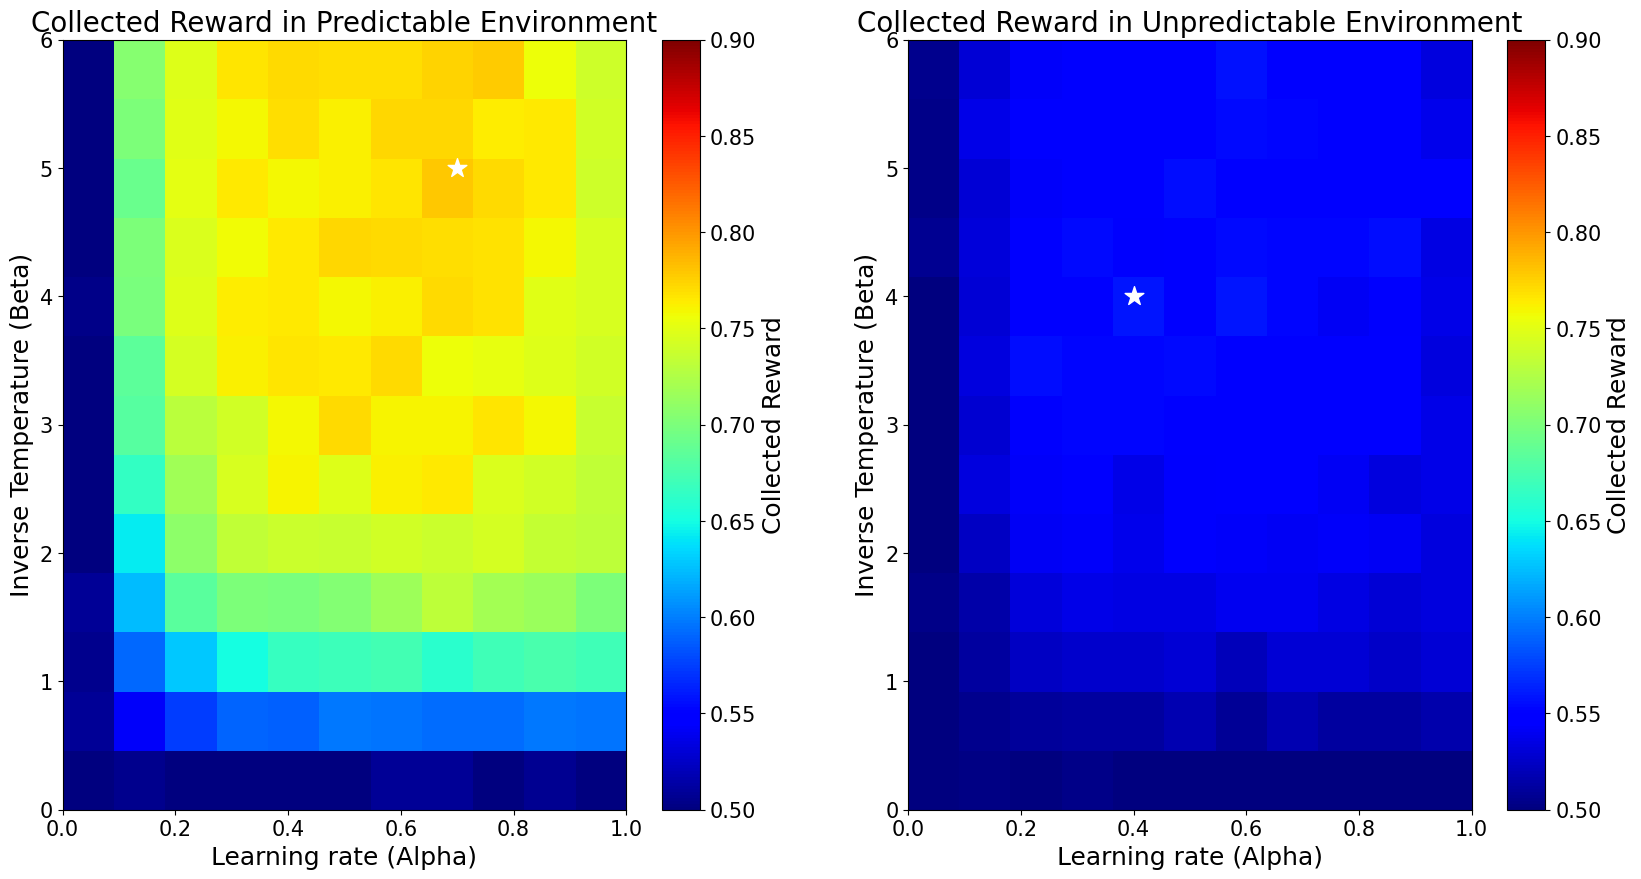

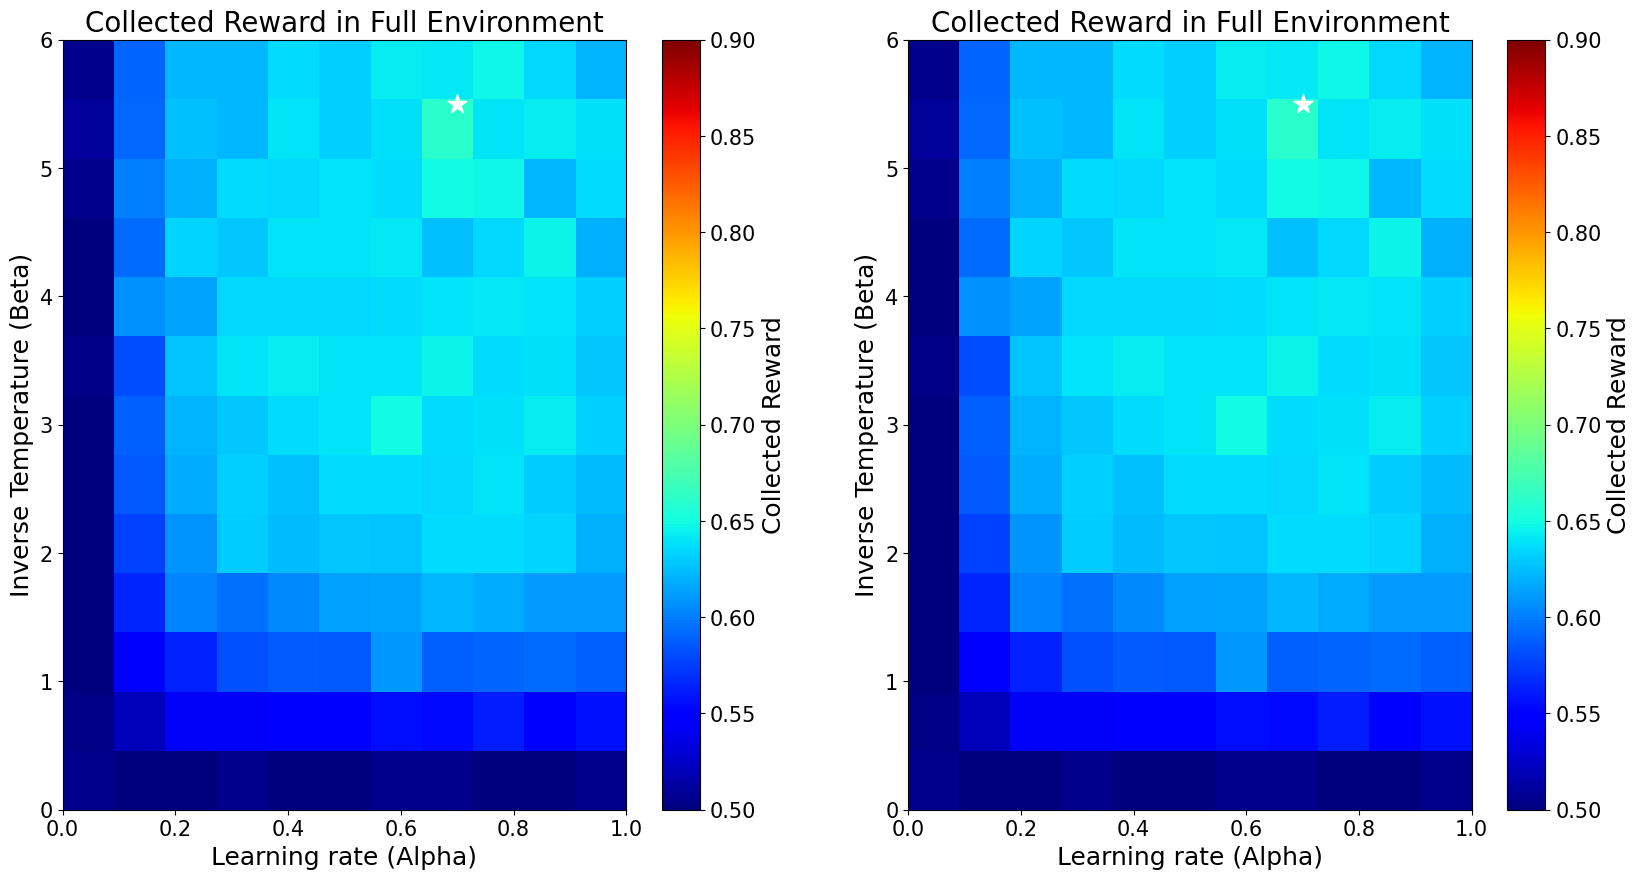

In [5]:
# Create meshgrid for alpha and beta values
alpha_vals, beta_vals = np.meshgrid(alpha_range, beta_range, indexing='ij')

figures = []
for fig_idx in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
    figures.append((fig, axes))

env_pairs = [
    (0, 1),
    (2, 3),
    (4, 5),
    (6, 6)
]

titles = [
    ('Volatility Controlled Environment', 'Extremity Controlled Environment'),
    ('Slowly Changing Environment', 'Fast Changing Environment'),
    ('Predictable Environment', 'Unpredictable Environment'),
    ('Full Environment', 'Full Environment')
]

for fig_idx, (env1, env2) in enumerate(env_pairs):
    fig, axes = figures[fig_idx]

    # First environment heatmap (alpha=x, beta=y)
    rewards_env1 = reward_matrix[:, :, env1].T
    im1 = axes[0].imshow(
        rewards_env1,
        origin='lower',
        aspect='auto',
        cmap='jet',
        vmin=0.5,
        vmax=0.9,
        extent=[alpha_range[0], alpha_range[-1], beta_range[0], beta_range[-1]]
    )
    max_idx_env1 = np.unravel_index(np.argmax(rewards_env1), rewards_env1.shape)
    axes[0].scatter(alpha_range[max_idx_env1[1]], beta_range[max_idx_env1[0]], c='white', marker='*', s=200)
    axes[0].set_title(f'Collected Reward in {titles[fig_idx][0]}')
    axes[0].set_ylabel('Inverse Temperature (Beta)')
    axes[0].set_xlabel('Learning rate (Alpha)')
    axes[0].grid(False)
    cbar1 = fig.colorbar(im1, ax=axes[0])
    cbar1.set_label('Collected Reward')

    # Second environment heatmap (alpha=x, beta=y)
    rewards_env2 = reward_matrix[:, :, env2].T
    im2 = axes[1].imshow(
        rewards_env2,
        origin='lower',
        aspect='auto',
        cmap='jet',
        vmin=0.5,
        vmax=0.9,
        extent=[alpha_range[0], alpha_range[-1], beta_range[0], beta_range[-1]]
    )
    max_idx_env2 = np.unravel_index(np.argmax(rewards_env2), rewards_env2.shape)
    axes[1].scatter(alpha_range[max_idx_env2[1]], beta_range[max_idx_env2[0]], c='white', marker='*', s=200)
    axes[1].set_title(f'Collected Reward in {titles[fig_idx][1]}')
    axes[1].set_ylabel('Inverse Temperature (Beta)')
    axes[1].set_xlabel('Learning rate (Alpha)')
    axes[1].grid(False)
    cbar2 = fig.colorbar(im2, ax=axes[1])
    cbar2.set_label('Collected Reward')

for fig, _ in figures:
    fig.show()

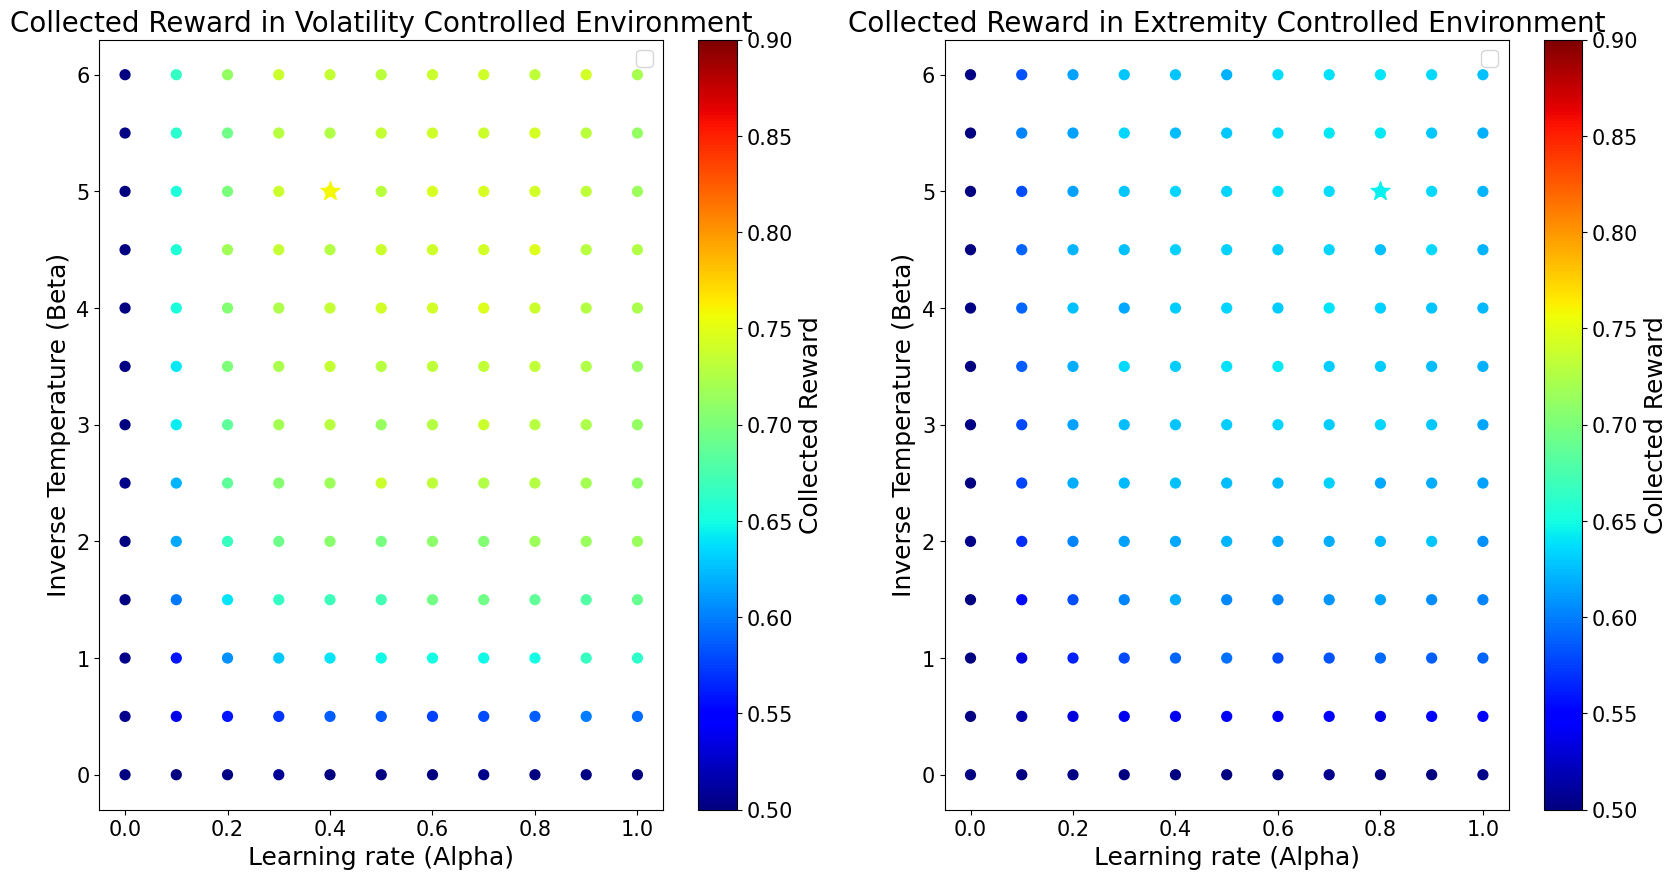

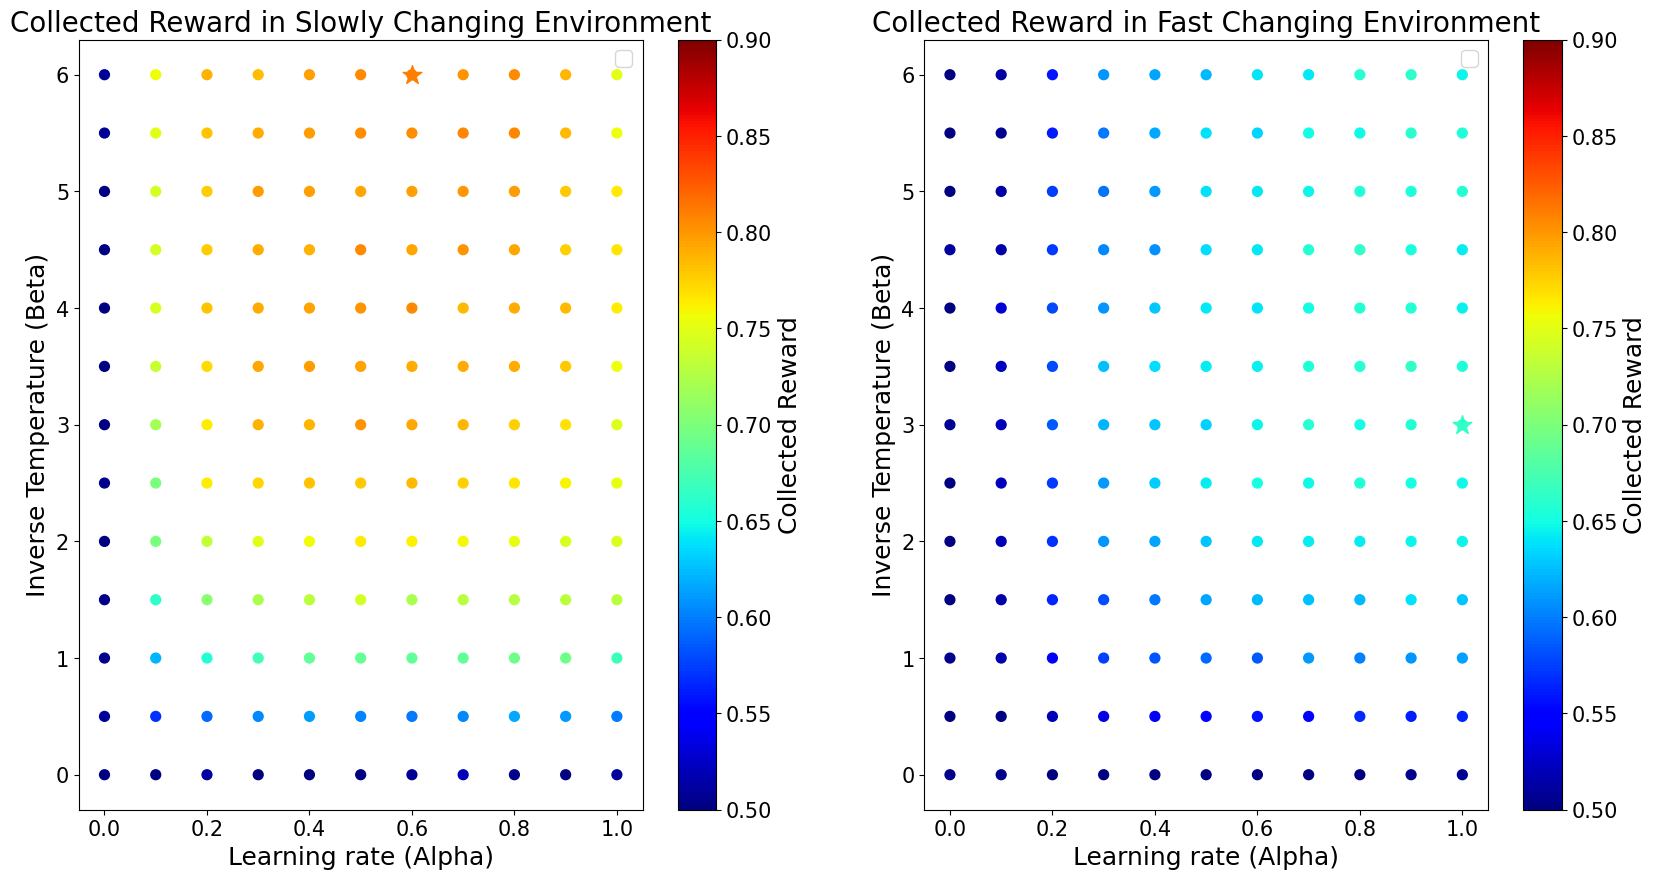

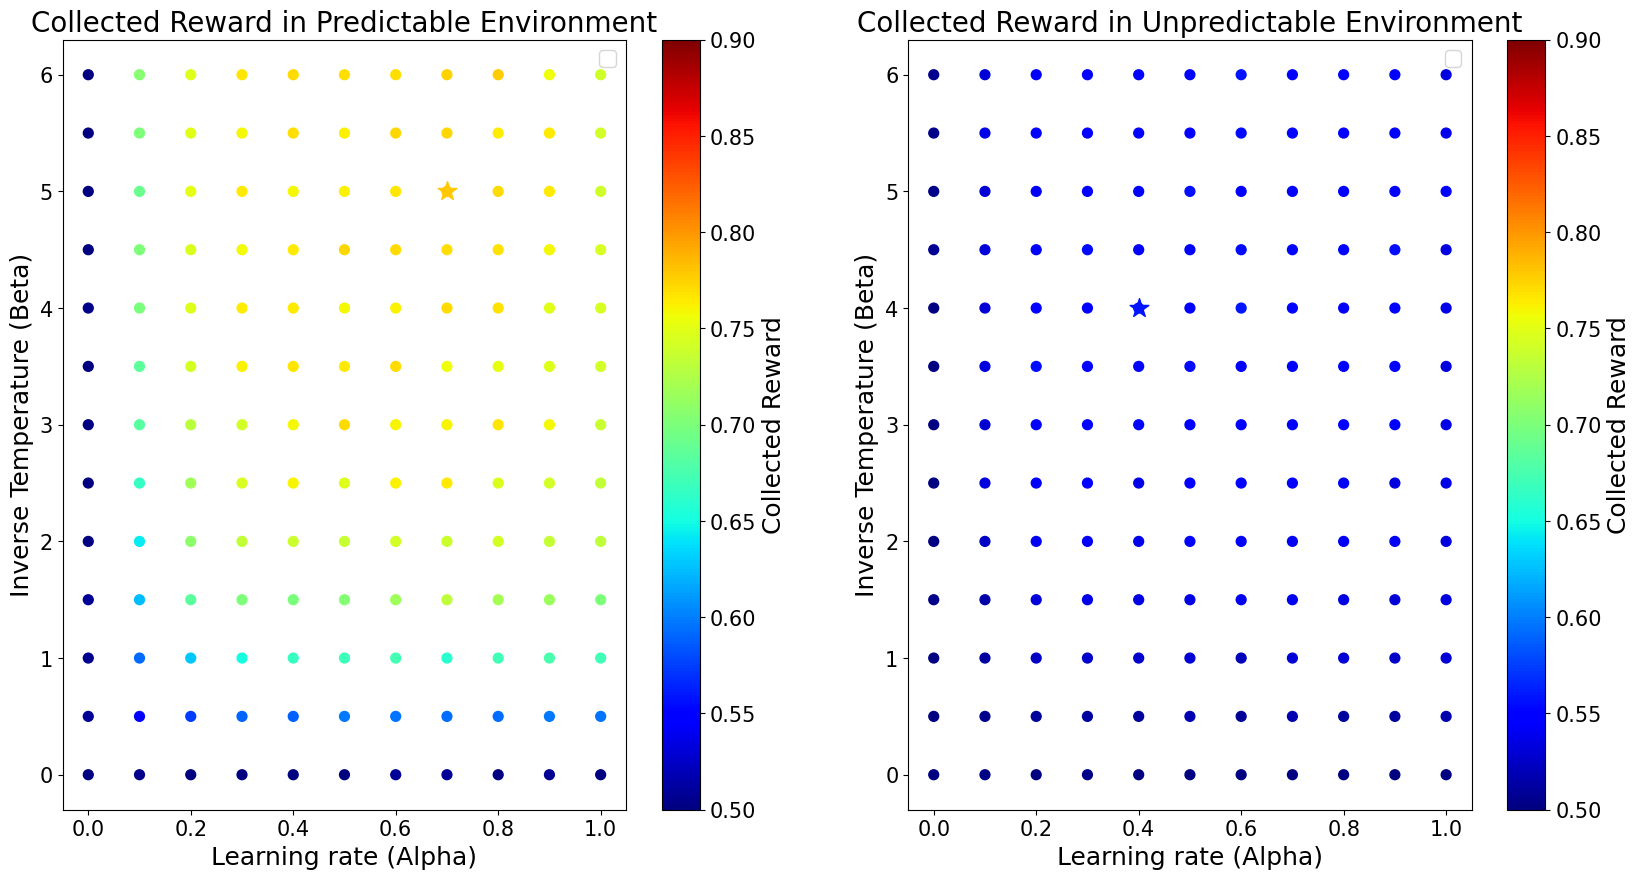

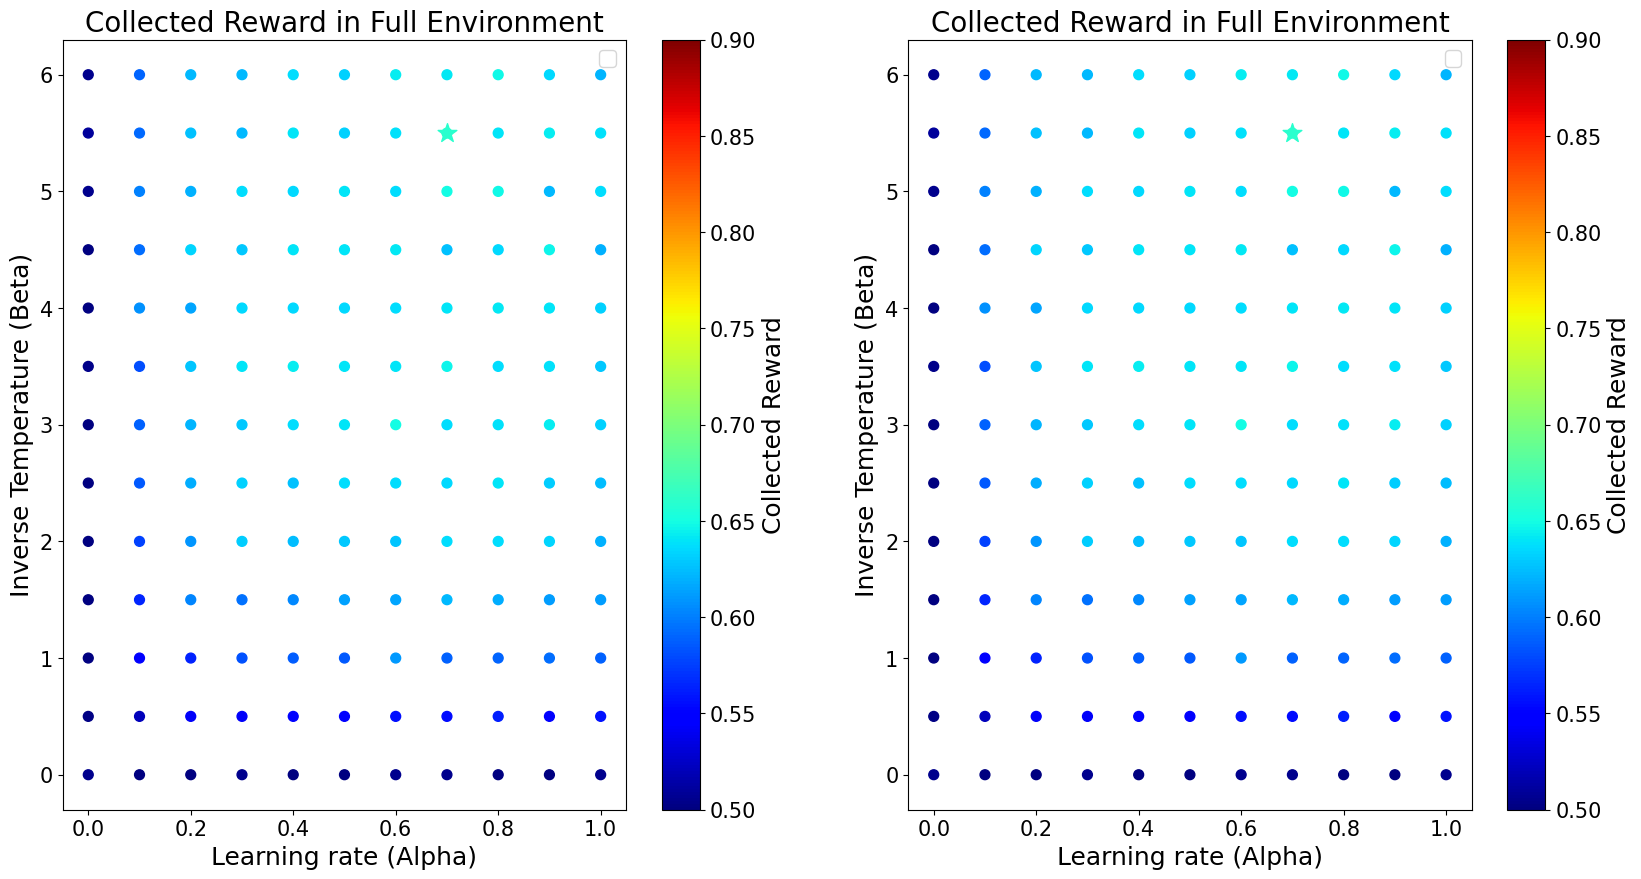

In [6]:
# Create meshgrid for alpha and beta values
alpha_vals, beta_vals = np.meshgrid(alpha_range, beta_range, indexing='ij')

# Create 3 figures, each with 2 subplots horizontally
figures = []
for fig_idx in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
    figures.append((fig, axes))

# Define environment pairs for comparison
env_pairs = [
    (0, 1),  # Volatility vs Extremity
    (2, 3),  # Slowly Changing vs Fast Changing
    (4, 5),  # Predictable vs Unpredictable 
    (6, 6)
]  

# Titles for the environment comparisons
titles = [
    ('Volatility Controlled Environment', 'Extremity Controlled Environment'),
    ('Slowly Changing Environment', 'Fast Changing Environment'),
    ('Predictable Environment', 'Unpredictable Environment'),
    ('Full Environment', 'Full Environment')
]

# Loop through each figure and environment pair
for fig_idx, (env1, env2) in enumerate(env_pairs):
    fig, axes = figures[fig_idx]
    
    # Subplot for the first environment in the pair
    rewards_env1 = reward_matrix[:, :, env1]
    max_idx_env1 = np.unravel_index(np.argmax(rewards_env1), rewards_env1.shape)
    scatter1 = axes[0].scatter(
        alpha_vals.flatten(), beta_vals.flatten(),
        c=rewards_env1.flatten(), cmap='jet', s=50, vmin=0.5, vmax=.9)
    axes[0].scatter(alpha_vals[max_idx_env1], beta_vals[max_idx_env1], c=rewards_env1[max_idx_env1] ,cmap='jet', vmin=0.5, vmax=0.9, marker='*', s=200)
    axes[0].set_title(f'Collected Reward in {titles[fig_idx][0]}')
    axes[0].set_ylabel('Inverse Temperature (Beta)')
    axes[0].set_xlabel('Learning rate (Alpha)')
    axes[0].grid(True)
    cbar1 = fig.colorbar(scatter1, ax=axes[0])  # Use the scatter plot directly for the color bar
    cbar1.set_label('Collected Reward')
    axes[0].legend()

    # Subplot for the second environment in the pair
    rewards_env2 = reward_matrix[:, :, env2]
    max_idx_env2 = np.unravel_index(np.argmax(rewards_env2), rewards_env2.shape)
    scatter2 = axes[1].scatter(
        alpha_vals.flatten(), beta_vals.flatten(),
        c=rewards_env2.flatten(), cmap='jet', s=50, vmin=0.5, vmax=0.9)
    axes[1].scatter(alpha_vals[max_idx_env2], beta_vals[max_idx_env2], c=rewards_env2[max_idx_env2] ,cmap='jet', vmin=0.5, vmax=0.9, marker='*', s=200)
    axes[1].set_title(f'Collected Reward in {titles[fig_idx][1]}')
    axes[1].set_ylabel('Inverse Temperature (Beta)')
    axes[1].set_xlabel('Learning rate (Alpha)')
    axes[1].grid(True)
    cbar2 = fig.colorbar(scatter2, ax=axes[1])  # Use the scatter plot directly for the color bar
    cbar2.set_label('Collected Reward')
    axes[1].legend()

# Show all figures
for fig, _ in figures:
    fig.show()

In [ ]:
#@title Set up environment
import random  # Import the random module

n_actions = 2
trialnum = 300 #@param {type:"integer"}
environment_full = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=[60,60,30,90], reward_probs=[0.9,0.7]) #, predif_sequence = [2,1,0,1,0,0,0,1,1])
# Generate a random sequence of 0s and 1s
# Generate a balanced random sequence of 0s and 1s

import numpy as np
import random
import matplotlib.pyplot as plt

# Define the parameter space
alpha_range = np.arange(0, 1.1, 0.1)  # Alpha values from 0 to 1 with 0.1 steps
beta_range = np.arange(0, 6.5, 0.5)   # Beta values from 0 to 5 with 0.1 steps

# Initialize a matrix to store collected rewards
reward_matrix = np.zeros((len(alpha_range), len(beta_range))) 

# Loop through the parameter space
for i, alpha in enumerate(alpha_range):
    for j, beta in enumerate(beta_range):
        # Define the RL parameters for the agent
        #@title Agent behavior: **One session**

        rewards_full_list = []
        # Run the experiment for each environment
        
        for _ in range(5000):  # Train 10 times
            agent = bandits.AgentQ(alpha=alpha, beta=beta, perseveration_bias=2)  

            experiment_full = bandits.run_flip_experiment(agent=agent,
                   environment=environment_full,
                   n_trials=trialnum)
            


            # Collect the average rewards
            rewards_full_list.append(sum(experiment_full.rewards)/len(experiment_full.rewards))

        # Store the average rewards in the reward matrix
        reward_matrix[i, j] = np.mean(rewards_full_list)



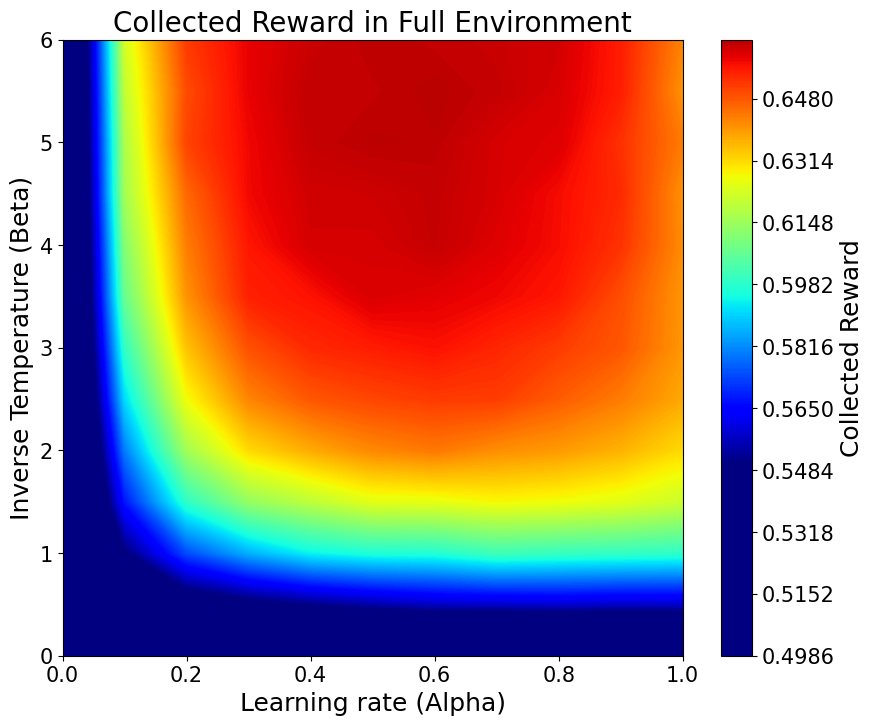

In [122]:
fig, ax = plt.subplots(figsize=(10, 8))
# Use contourf for a smooth heatmap

contour = ax.contourf(
    alpha_vals, beta_vals, reward_matrix[:,:,1],
    levels=1000, cmap='jet'
)
max_idx_env = np.unravel_index(np.argmax(rewards_env), rewards_env.shape)
#ax.scatter(alpha_range[max_idx_env[1]], beta_range[max_idx_env[0]], c='white', marker='*', s=200)
ax.set_title(f'Collected Reward in {titles[fig_idx][0]}')
ax.set_ylabel('Inverse Temperature (Beta)')
ax.set_xlabel('Learning rate (Alpha)')
ax.grid(False)
contour.set_clim(0.55, 0.67)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Collected Reward')

fig.savefig("/Users/kiralyb/Documents/COSYNE/exportedfigs/collected_reward_vector.svg", format="svg")
fig.savefig("/Users/kiralyb/Documents/COSYNE/exportedfigs/collected_reward_vector.pdf", format="pdf")
plt.show()

